# Feature Engineering

This notebook will compute all the features.

The features will consist of:
- Rolling aggregates (mean, max, std) of anglez and enmo over a variety of window sizes, from 5 minutes to 8 hours.
- Rolling aggregates (mean, max, std) of anglez and enmo total variation (or first variation, i.e. 1v) over a variety of window sizes, from 5 minutes to 8 hours.


https://www.kaggle.com/code/lccburk/feature-engineering-and-random-forest-prediction

# GPT REVIEW


Data Types: Casting aggregates like mean and std to UInt16 may not be suitable if the rolling aggregates can have decimal places. Typically, aggregates are kept as float types.

Multiplying by 10: In the "Getting first variations" section, the results of rolling mean, max, and std of first differences are multiplied by 10. Ensure this operation is meaningful and necessary for your feature scaling or representation.

Abs before Cast: The code is taking the absolute value before casting, which makes sense for the max operation, but for mean and std, you would typically want to preserve the sign unless the domain specifically requires absolute values.

Circular Features: In the to_coord function, the expression (x % max_) is redundant since x should already be in the range [0, max_), assuming x is an hour, day, or month

**Imports**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

from tqdm import tqdm

**Parameters**

In [3]:
WINDOW_SIZES = [5, 30, 2*60, 8*60] # 5min, 30min, 2hours, 8hours

ID_COLUMNS = ['series_id', 'step', 'timestamp']

TIME_COLUMNS = ['second', 'minute', 'hour', 'day', 'month']

FEATURE_TIME_NAMES = [
    "hour_sin",
    "hour_cos",
    "month_sin",
    "month_cos",
    "minute_sin",
    "minute_cos",
    "anglez_sin",
    "anglez_cos",
]


In [4]:
def add_timestamp_columns(df):
    """
    Add timestamp-related columns to a Polars DataFrame.

    Parameters
    ----------
    df : pl.DataFrame
        The input Polars DataFrame containing a 'timestamp' column.

    Returns
    -------
    pl.DataFrame
        A new Polars DataFrame with additional columns for year, month, day,
        hour, minute, and second extracted from the 'timestamp' column.
    """
    df = (
        df
        .with_row_count('step')
        .with_columns(
            year=df['timestamp'].dt.year().cast(pl.Int16),
            month=df['timestamp'].dt.month().cast(pl.Int8),
            day=df['timestamp'].dt.day().cast(pl.Int8),
            hour=df['timestamp'].dt.hour().cast(pl.Int8),
            minute=df['timestamp'].dt.minute().cast(pl.Int8),
            second=df['timestamp'].dt.second().cast(pl.Int8),
        )
    )
    return df

**Rolling Features**

In [5]:
def add_rolling_features(df, WINDOW_SIZES, var_list=['enmo', 'anglez']):
    """
    Generate windowed features for a given Polars DataFrame.

    Parameters
    ----------
    df : pl.DataFrame
        The input Polars DataFrame.
    WINDOW_SIZES : list of int
        A list of window sizes in minutes for rolling calculations.
    var_list : list of str, optional
        A list of column names to calculate features for, by default ['enmo', 'anglez'].

    Returns
    -------
    pl.DataFrame
        A new Polars DataFrame with windowed features added based on the specified window sizes
        and columns in var_list.
    """
    features, feature_cols = [], []

    for mins in WINDOW_SIZES:
        for var in var_list:

            # Getting basic features
            features += [
                pl.col(var).rolling_mean(2 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'{var}_{mins}m_mean'),
                pl.col(var).rolling_max(2 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'{var}_{mins}m_max'),
                pl.col(var).rolling_std(2 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'{var}_{mins}m_std')
            ]

            feature_cols += [
                f'{var}_{mins}m_mean', f'{var}_{mins}m_max', f'{var}_{mins}m_std'
            ]

            # Getting first variations
            features += [
                (pl.col(var).diff().abs().rolling_mean(2 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_mean'),
                (pl.col(var).diff().abs().rolling_max(2 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_max'),
                (pl.col(var).diff().abs().rolling_std(2 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_std')
            ]

            feature_cols += [
                f'{var}_1v_{mins}m_mean', f'{var}_1v_{mins}m_max', f'{var}_1v_{mins}m_std'
            ]

    train_series = df.with_columns(features)

    return train_series

**Circular Features**

In [6]:
def to_coord(x: pl.Expr, max_: int, name: str) -> list[pl.Expr]:
    """
    Convert a Polar coordinate to its sine and cosine components.

    Parameters
    ----------
    x : pl.Expr
        The input expression representing the Polar coordinate.
    max_ : int
        The maximum value for the coordinate (e.g., 24 for hours, 12 for months, 60 for minutes).
    name : str
        The name for the coordinate component.

    Returns
    -------
    list[pl.Expr]
        A list containing two expressions representing the sine and cosine components of the coordinate.
    """
    rad = 2 * np.pi * (x % max_) / max_
    x_sin = rad.sin()
    x_cos = rad.cos()

    return [x_sin.alias(f"{name}_sin"), x_cos.alias(f"{name}_cos")]

def add_circular_feature(series_df: pl.DataFrame) -> pl.DataFrame:
    """
    Add sine and cosine components of specific Polar coordinates to a Polars DataFrame.

    Parameters
    ----------
    series_df : pl.DataFrame
        The input Polars DataFrame.

    Returns
    -------
    pl.DataFrame
        A new Polars DataFrame with sine and cosine components added for 'hour', 'month', 'minute',
        'anglez' columns.
    """
    series_df = (
        series_df
        .with_columns(
            *to_coord(pl.col("hour"), 24, "hour"),
            *to_coord(pl.col("month"), 12, "month"),
            *to_coord(pl.col("minute"), 60, "minute"),
            pl.col('anglez').sin().alias('anglez_sin'),
            pl.col('anglez').cos().alias('anglez_cos'),
        )
    )
    return series_df


In [7]:
df = pl.read_parquet('data/train_dataset.parquet')


In [13]:
series_name = df['series_id'].unique()

In [26]:
df_feature = df.filter(
    pl.col('series_id').is_in(series_name.sample(40)),
)

In [28]:
df_feature = add_timestamp_columns(df_feature)
df_feature = add_circular_feature(df_feature)
df_feature = add_rolling_features(df_feature, WINDOW_SIZES)

In [29]:
df_feature.write_parquet('data/train_dataset_feature.parquet')

: 

## Apply

In [9]:
df = pl.read_parquet('data/train_dataset.parquet')
df = add_timestamp_columns(df)
df = add_circular_feature(df)
df = add_rolling_features(df, WINDOW_SIZES)

In [14]:
series = df['series_id'].unique()

In [7]:
df = pl.read_parquet('data/78569a801a38.parquet')
df = add_timestamp_columns(df)
df = add_rolling_features(df, WINDOW_SIZES)
df = add_circular_feature(df)

In [13]:
df2 = pl.read_parquet('data/f564985ab692.parquet')

df2 = add_timestamp_columns(df2)
df2 = add_rolling_features(df2, WINDOW_SIZES)
df2 = add_circular_feature(df2)

## Machine Learning

In [7]:
y = df['state']
X = df[list(set(df.columns) - set(ID_COLUMNS))]

In [14]:
y2 = df2['state']
X2 = df2[list(set(df2.columns) - set(ID_COLUMNS))]

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=0)

In [15]:
y_pred = clf.predict(X2)

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

accuracy_score(y2, y_pred)

0.9924858950247906

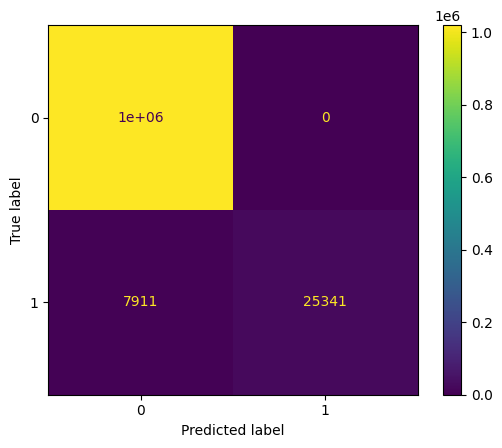

In [17]:
cm = confusion_matrix(y2, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()